Market Basket Analysis using instacart data

Ingesting data from data source files

In [0]:
aisles = spark.read.csv("/FileStore/shared_uploads/dhanasree.rajamani@sjsu.edu/aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("/FileStore/shared_uploads/dhanasree.rajamani@sjsu.edu/departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("/FileStore/shared_uploads/dhanasree.rajamani@sjsu.edu/order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv("/FileStore/shared_uploads/dhanasree.rajamani@sjsu.edu/order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv("/FileStore/shared_uploads/dhanasree.rajamani@sjsu.edu/orders.csv", header=True, inferSchema=True)
products = spark.read.csv("/FileStore/shared_uploads/dhanasree.rajamani@sjsu.edu/products.csv", header=True, inferSchema=True)

# Create Temporary View
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Trying a couple approaches: 
- with python 
- with sql and scala

import statements

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import os
import zipfile
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Converting spark to pandas dataframe

In [0]:
orders_df = orders.select("*").toPandas()
order_products_prior_df = order_products_prior.select("*").toPandas()
order_products_train_df = order_products_train.select("*").toPandas()
products_df = products.select("*").toPandas()
departments_df = departments.select("*").toPandas()
aisles_df = aisles.select("*").toPandas()

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
order_products_train_df

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


Merge datasets

In [0]:
df2 = order_products_train_df.merge(products_df, on='product_id')
df2.columns, df2.shape

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Out[24]: (Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id'],
       dtype='object'),
 (1384617, 7))

In [0]:
df2['aisle_id']=df2['aisle_id'].astype(int)

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
aisles_df['aisle_id']=aisles_df['aisle_id'].astype(int)

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
df3 = df2.merge(aisles_df, on='aisle_id')
df3.columns, df3.shape

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Out[42]: (Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id', 'aisle'],
       dtype='object'),
 (1384617, 8))

In [0]:
df4 = df3.merge(orders_df, on='order_id')
df4.columns, df4.shape

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Out[43]: (Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id', 'aisle', 'user_id',
        'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order'],
       dtype='object'),
 (1384617, 14))

In [0]:
df4['department_id'] = df4['department_id'].astype(int)

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
departments_df['department_id'] = departments_df['department_id'].astype(int)

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
df5 = df4.merge(departments_df, on='department_id')
df5.columns, df5.shape

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Out[48]: (Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
        'product_name', 'aisle_id', 'department_id', 'aisle', 'user_id',
        'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order', 'department'],
       dtype='object'),
 (1384617, 15))

In [0]:
df5.head()

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,112108,train,4,4,10,9.0,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,112108,train,4,4,10,9.0,dairy eggs
2,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,112108,train,4,4,10,9.0,dairy eggs
3,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,47901,train,14,4,6,16.0,dairy eggs
4,816049,35176,5,1,Cream Cheese Cream Cheese Spread,108,16,other creams cheeses,47901,train,14,4,6,16.0,dairy eggs


Exploring the data

Get frequency of orders on weekdays

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


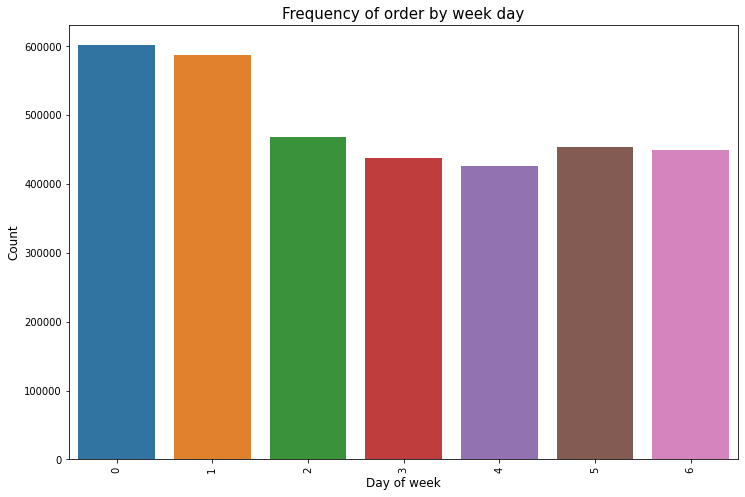

In [0]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Frequency of orders by hour of the day

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


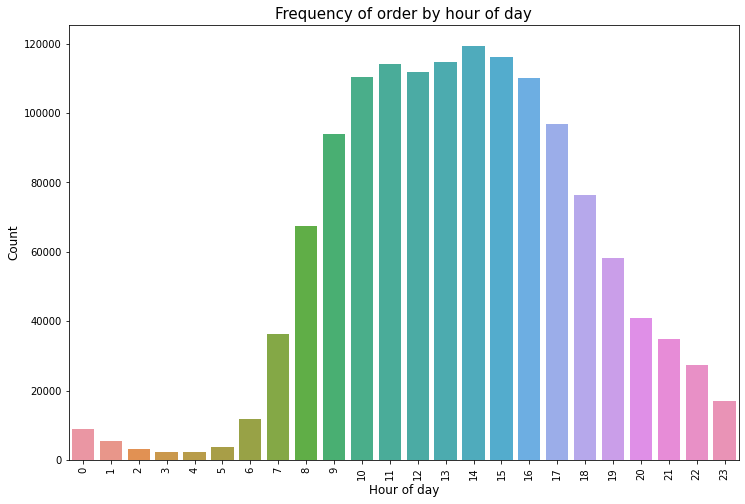

In [0]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=df5)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

Group orders by products and count of how many times each product was ordered

In [0]:
g = df5.product_id.value_counts()
g = pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["product_id", "count"]
g_products = g.merge(products_df, on="product_id")
g_products.head()

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,product_id,count,product_name,aisle_id,department_id
0,24852,18726,Banana,24,4
1,13176,15480,Bag of Organic Bananas,24,4
2,21137,10894,Organic Strawberries,24,4
3,21903,9784,Organic Baby Spinach,123,4
4,47626,8135,Large Lemon,24,4


Get most ordered products

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<Figure size 3600x2880 with 0 Axes>

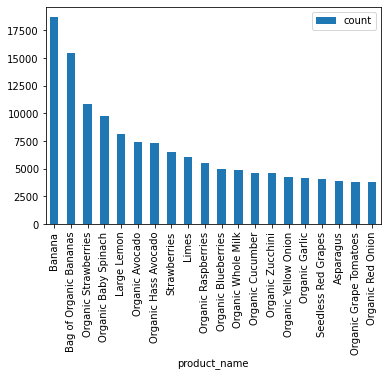

In [0]:
plt.figure(figsize=(50, 40))
g_products.head(20).plot(kind="bar", x="product_name", y="count")
plt.show()

Find number of order per department

In [0]:
g = df5.department_id.value_counts()
g = pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["department_id", "count"]
g_dept = g.merge(departments_df, on="department_id")
g_dept.head()

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,department_id,count,department
0,4,409087,produce
1,16,217051,dairy eggs
2,19,118862,snacks
3,7,114046,beverages
4,1,100426,frozen


/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


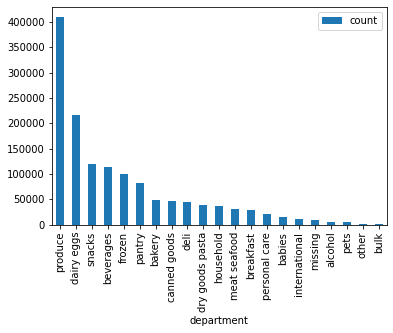

In [0]:
g_dept.plot(kind="bar", x="department", y="count")
plt.show()

Getting products that are reordered and not reordered

In [0]:
df5[df5['reordered'] == 1]['product_id'].max() #nunique()

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Out[60]: 49688

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplo

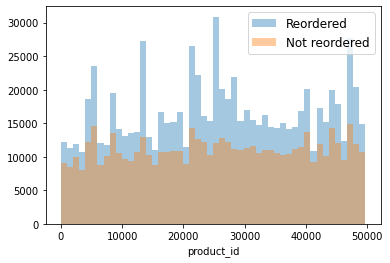

In [0]:
sns.distplot(df5[df5['reordered'] == 1]['product_id'], kde=False, label='Reordered')
sns.distplot(df5[df5['reordered'] == 0]['product_id'], kde=False, label='Not reordered')

plt.legend(prop={'size': 12})
plt.show()

plot the heatmap of Re-ordered ratio of week vs hour of the day

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


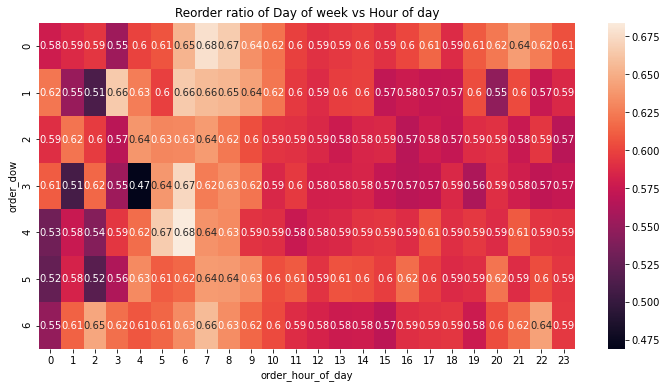

In [0]:
grouped_df = df5.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12, 6))
sns.heatmap(grouped_df, annot=True)
plt.title("Reorder ratio of Day of week vs Hour of day")
plt.show()

Creating a basket

Taking a subset of data to extract association rules from it

Segmenting data by 100 most frequently ordered items

In [0]:
product_counts = df5.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop=True)
product_counts.head(10)

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,product_id,frequency
0,24852,18726
1,13176,15480
2,21137,10894
3,21903,9784
4,47626,8135
5,47766,7409
6,47209,7293
7,16797,6494
8,26209,6033
9,27966,5546


In [0]:
freq_products = list(product_counts.product_id)
freq_products[1:10]

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Out[64]: [13176, 21137, 21903, 47626, 47766, 47209, 16797, 26209, 27966]

In [0]:
order_products = df5[df5.product_id.isin(freq_products)]
order_products.shape

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Out[66]: (314227, 15)

In [0]:
basket = order_products.pivot_table(columns='product_name', values='reordered', index='order_id').reset_index().fillna(0).set_index('order_id')

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket = basket.applymap(encode_units)
basket.head()

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


product_name,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,...,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Apply apriori algorithm

Using a subset of the data, to extract association rules from it

In [0]:
shortbasket = basket[:100000]

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
frequent_items = apriori(shortbasket, min_support=0.01, use_colnames=True)
frequent_items.head()

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-659b77de-dd6b-4c7f-8f4a-acc81970722c/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.018668,(100% Whole Wheat Bread)
1,0.013298,(2% Reduced Fat Milk)
2,0.017304,(Apple Honeycrisp Organic)
3,0.026180,(Asparagus)
4,0.142376,(Bag of Organic Bananas)


In [0]:
rules = association_rules(frequent_items, metric='lift', min_threshold=1)
rules.sort_values('confidence', ascending=False)

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.064379,0.142376,0.021449,0.333168,2.340054,0.012283,1.286117
4,(Organic Raspberries),(Bag of Organic Bananas),0.045594,0.142376,0.014811,0.324842,2.281578,0.008319,1.270257
16,(Strawberries),(Banana),0.050996,0.176420,0.015248,0.298997,1.694804,0.006251,1.174860
10,(Organic Avocado),(Banana),0.066340,0.176420,0.019318,0.291198,1.650598,0.007614,1.161933
31,(Organic Raspberries),(Organic Strawberries),0.045594,0.091668,0.013074,0.286749,3.128143,0.008895,1.273511
6,(Organic Strawberries),(Bag of Organic Bananas),0.091668,0.142376,0.025456,0.277694,1.950424,0.012404,1.187341
8,(Large Lemon),(Banana),0.063111,0.176420,0.016537,0.262029,1.485260,0.005403,1.116007
19,(Limes),(Large Lemon),0.045115,0.063111,0.010325,0.228862,3.626315,0.007478,1.214942
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.085828,0.142376,0.018498,0.215518,1.513725,0.006278,1.093236
29,(Organic Hass Avocado),(Organic Strawberries),0.064379,0.091668,0.012637,0.196293,2.141353,0.006736,1.130178


Using SQL and Scala

Organize and view shopping basket

In [0]:
# Organize the data by shopping basket
from pyspark.sql.functions import collect_set, col, count
rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [0]:
display(baskets)

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


order_id,items
762,"List(Organic Cucumber, Organic Romaine Lettuce, Celery Hearts, Organic Strawberries)"
844,"List(Organic Red Radish, Bunch, Baby Spinach, Organic Shredded Carrots, Granny Smith Apples, Green Beans, Cheese Pizza Snacks, Garlic Couscous)"
988,"List(Whipped Light Cream, Original, Complete ActionPacs Lemon Burst Dishwasher Detergent, Classic Vanilla Coffee Creamer, Natural Vanilla Ice Cream)"
1139,"List(Cinnamon Rolls with Icing, Red Vine Tomato, Picnic Potato Salad, Flaky Biscuits, Organic Strawberries, Organic Bakery Hamburger Buns Wheat - 8 CT, Buttermilk Biscuits, Banana, Guacamole)"
1143,"List(Water, Natural Premium Coconut Water, Organic Red Radish, Bunch, Organic Capellini Whole Wheat Pasta, Organic Raspberries, Calming Lavender Body Wash, Organic Garlic, Rustic Baguette, Organic Brussel Sprouts, Organic Butterhead (Boston, Butter, Bibb) Lettuce, Organic Blueberries, Spring Water, Large Lemon, Basil Pesto, Baby Arugula, Organic Hass Avocado, Unscented Long Lasting Stick Deodorant)"
1280,"List(Vanilla Soy Milk, French Vanilla Creamer, Organic Half & Half, Lactose Free Half & Half, Organic Whole Milk)"
1342,"List(Raw Shrimp, Seedless Cucumbers, Versatile Stain Remover, Organic Strawberries, Organic Mandarins, Chicken Apple Sausage, Pink Lady Apples, Bag of Organic Bananas)"
1350,"List(Mocha Frappucino Chilled Coffee Drink, Bare Fruit Banana Chips, Pressed Cool Pineapple, Ground Cinnamon, Lemon Love Juice Drink, Chia Sweet Peach Smoothie, Green Apple Chips, Sea Salt Chickpeas, Plus Lotion Facial Tissues, Organic Insect Repellent Fresh Natural Scent, Strawberry Banana Juice)"
1468,"List(Pomegranate Seeds, Organic Red Radish, Bunch, Natural Mini Pork Pepperoni, Cage Free Grade AA Large White Eggs, Bartlett Pears, Organic Red Potato, Organic Ginger Root, Banana, Red Peppers, Active Dry Yeast, Organic Lacinato (Dinosaur) Kale, Organic Baby Broccoli, Carrots, Fresh Cauliflower, Organic English Cucumber, Organic Grape Tomatoes, Organic Hass Avocado)"
1591,"List(Cracked Wheat, Strawberry Rhubarb Yoghurt, Organic Bunny Fruit Snacks Berry Patch, Goodness Grapeness Organic Juice Drink, Honey Graham Snacks, Spinach, Granny Smith Apples, Oven Roasted Turkey Breast, Pure Vanilla Extract, Chewy 25% Low Sugar Chocolate Chip Granola, Banana, Original Turkey Burgers Smoke Flavor Added, Twisted Tropical Tango Organic Juice Drink, Navel Oranges, Lower Sugar Instant Oatmeal Variety, Ultra Thin Sliced Provolone Cheese, Natural Vanilla Ice Cream, Cinnamon Multigrain Cereal, Garlic, Goldfish Pretzel Baked Snack Crackers, Original Whole Grain Chips, Medium Scarlet Raspberries, Lemon Yogurt, Original Patties (100965) 12 Oz Breakfast, Nutty Bars, Strawberry Banana Smoothie, Green Machine Juice Smoothie, Coconut Dreams Cookies, Buttermilk Waffles, Uncured Genoa Salami, Organic Greek Whole Milk Blended Vanilla Bean Yogurt)"


Train ML model
Using FP Growth and Scala

In [0]:
%scala
import org.apache.spark.ml.fpm.FPGrowth

// Extract out the items 
val baskets_ds = spark.sql("select items from baskets").as[Array[String]].toDF("items")

// Use FPGrowth
val fpgrowth = new FPGrowth().setItemsCol("items").setMinSupport(0.001).setMinConfidence(0)
val model = fpgrowth.fit(baskets_ds)

import org.apache.spark.ml.fpm.FPGrowth
baskets_ds: org.apache.spark.sql.DataFrame = [items: array<string>]
fpgrowth: org.apache.spark.ml.fpm.FPGrowth = fpgrowth_9cd0cea954bb
model: org.apache.spark.ml.fpm.FPGrowthModel = FPGrowthModel: uid=fpgrowth_9cd0cea954bb, numTrainingRecords=131209

Most frequent Itemsets

In [0]:
%scala
// Display frequent itemsets
val mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

mostPopularItemInABasket: org.apache.spark.sql.DataFrame = [items: array<string>, freq: bigint]

In [0]:
%sql
select items, freq from mostPopularItemInABasket where size(items) > 2 order by freq desc limit 20

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


items,freq
"List(Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas)",710
"List(Organic Raspberries, Organic Strawberries, Bag of Organic Bananas)",649
"List(Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas)",587
"List(Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas)",531
"List(Organic Hass Avocado, Organic Baby Spinach, Bag of Organic Bananas)",497
"List(Organic Avocado, Organic Baby Spinach, Banana)",484
"List(Organic Avocado, Large Lemon, Banana)",477
"List(Limes, Large Lemon, Banana)",452
"List(Organic Cucumber, Organic Strawberries, Bag of Organic Bananas)",424
"List(Limes, Organic Avocado, Large Lemon)",389


View generated Association rules

In [0]:

%scala
// Display generated association rules.
val ifThen = model.associationRules
ifThen.createOrReplaceTempView("ifThen")

ifThen: org.apache.spark.sql.DataFrame = [antecedent: array<string>, consequent: array<string> ... 3 more fields]

In [0]:
%sql
select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence from ifThen order by confidence desc limit 20

/databricks/python/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedent (if),consequent (then),confidence
"List(Organic Raspberries, Organic Hass Avocado, Organic Strawberries)",List(Bag of Organic Bananas),0.5984251968503937
"List(Organic Cucumber, Organic Hass Avocado, Organic Strawberries)",List(Bag of Organic Bananas),0.546875
"List(Organic Kiwi, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5459770114942529
"List(Organic Navel Orange, Organic Raspberries)",List(Bag of Organic Bananas),0.5412186379928315
"List(Yellow Onions, Strawberries)",List(Banana),0.5357142857142857
"List(Organic Whole String Cheese, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5314685314685315
"List(Organic Navel Orange, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5283018867924528
"List(Organic Raspberries, Organic Hass Avocado)",List(Bag of Organic Bananas),0.521099116781158
"List(Organic D'Anjou Pears, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5170454545454546
"List(Organic Unsweetened Almond Milk, Organic Hass Avocado)",List(Bag of Organic Bananas),0.5141065830721003
